# Title selection for feature version 1

**Motivation:**  
This script selects **only** titles for *feature version 2*.  
Another notebook will merge the features selected here with additional features such as `dynasty`, `father_was_vizier`, and `PCA` components.

**Version 2 definition:**
- Perform feature selection for titles based on both `P(vizier | title)` and `P(title | vizier)`.
- Final selection criteria: a title must satisfy the following conditions:
    - `count(title) > 10`  
    **AND**  
    - `(P(vizier | title) > 0.5000)` **OR** `(P(title | vizier) > 0.1250)`


### loads

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import set_path
import supp.support_load as sl
from supp.support_load import read_csv, read_excel
from supp.support_merge import merge, group_to_list
from supp.support_save import save_df
from supp.support_constants import VIZIER_IDS, PATH_DATA_MERGED

In [2]:
# load database
dfs, dfs_name, dfs_export_date = sl.load_pickle()
iton, ntoi = sl.get_name_dicts(dfs_name)
dfs_export_date

Pickle database loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\dfs_complete.pickle
Applied preprocessing: merge_on_jones
Applied preprocessing: remove_jones_duplicates


'2024-10-11'

In [3]:
# load dataframe with binary encoded titles
vizier__35_title_list = read_csv('vizier__35_title_list')
print(f'{vizier__35_title_list.shape}\tshape of vizier__35_title_list')
vizier__35_title_list.head(2)

CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\unpacked\df_person_all\merged\vizier__35_title_list.csv
(4962, 2184)	shape of vizier__35_title_list


,ID_person,vizier,(cmcw ?) wxrt aAt,(wnn) imAx.c nfr xr Ra nb Axt(y),... 1p,... BA-Nfr-ir-kA-ra,... Hct n xnt[yw-S],... Hm(w)-nTr ... m Cxt-Ra,... Hm-kA,... Hm-nTr 1wt-1r,...,zmAwt mry Nbty ncwt,zwnw,zwnw Xt pr-aA,zwnw cmcw pr-aA,zwnw irty,zwnw irty pr-aA,zwnw pr-aA,zš (n) (i)m(yw) zA 20 (n) niwt mr,zš (n) (i)m(yw) zA 20 (n) niwt mr Mn-anx-Nfr-kA-ra,zš wab 200 pr-aA
0,322,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,323,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# read df sex of all persons
df_sex = read_csv('08_sex')
print(f'{df_sex.shape}\tshape of df_sex')
df_sex.head()

CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\unpacked\df_person_all\08_sex.csv
(4962, 3)	shape of df_sex


,ID_person,female,male
0,322,0.0,1.0
1,323,0.0,1.0
2,324,0.0,1.0
3,325,0.0,1.0
4,326,0.0,1.0


In [5]:
# get df_titles
df_titles = dfs[ntoi['df_titles']]
print(f'{df_titles.shape}\tshape of df_titles')

(2219, 24)	shape of df_titles


### restriction to only male persons

In [6]:
# RESTRICTION
# make df of only males
id_male = df_sex.loc[df_sex['male']==1, 'ID_person']
mask = vizier__35_title_list['ID_person'].isin(id_male)
df_vizier_title_male = vizier__35_title_list.loc[mask, :]
print(f'{df_vizier_title_male.shape}\tshape of df_vizier_title_male')
df_vizier_title_male.head(2)

(3930, 2184)	shape of df_vizier_title_male


,ID_person,vizier,(cmcw ?) wxrt aAt,(wnn) imAx.c nfr xr Ra nb Axt(y),... 1p,... BA-Nfr-ir-kA-ra,... Hct n xnt[yw-S],... Hm(w)-nTr ... m Cxt-Ra,... Hm-kA,... Hm-nTr 1wt-1r,...,zmAwt mry Nbty ncwt,zwnw,zwnw Xt pr-aA,zwnw cmcw pr-aA,zwnw irty,zwnw irty pr-aA,zwnw pr-aA,zš (n) (i)m(yw) zA 20 (n) niwt mr,zš (n) (i)m(yw) zA 20 (n) niwt mr Mn-anx-Nfr-kA-ra,zš wab 200 pr-aA
0,322,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,323,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### functions

In [7]:
def conditional_probability(df, col1, col2):
    """
    Calculate the conditional probability P(col1=1 | col2=1) in a binary dataframe.
    
    Args:
    df (pd.DataFrame): Input DataFrame with binary values (0 or 1).
    col1 (str): The column for which probability is calculated (dependent variable).
    col2 (str): The column given as condition (independent variable).

    Returns:
    float: The conditional probability P(col1=1 | col2=1)
    """
    # If col1 or col2 is not valid column name, return nan
    if col1 not in df.columns or col2 not in df.columns:
        return np.nan
    
    # Count occurrences where both col1 and col2 are 1
    joint_count = ((df[col1] == 1) & (df[col2] == 1)).sum()
    
    # Count occurrences where col2 is 1
    col2_count = (df[col2] == 1).sum()
    
    # Compute conditional probability
    if col2_count == 0:
        return 0  # Avoid division by zero

    probability = joint_count / col2_count
    return round(probability, 4)

In [8]:
def get_count(df, col1):
    """
    Calculate the probability P(col1=1) in a binary dataframe.
    
    Args:
    df (pd.DataFrame): Input DataFrame with binary values (0 or 1).
    col1 (str): The column for which probability is calculated (dependent variable).

    Returns:
    float: The conditional probability P(col1=1)
    """
    # If col1 or col2 is not valid column name, return nan
    if col1 not in df.columns:
        return np.nan
    
    # Count occurrences where both col1 and col2 are 1
    count = (df[col1] == 1).sum()

    return int(count)

### make dataframe with conditional probabilites

In [9]:
data_list = []
for col in df_vizier_title_male.columns:
    # do not compute stats for 'ID_person'
    if col == 'ID_person':
        continue
    # compute probabilities and count
    p_vizier_title = conditional_probability(df_vizier_title_male, 'vizier', col)
    p_title_vizier = conditional_probability(df_vizier_title_male, col, 'vizier')
    count = get_count(df_vizier_title_male, col)

    d = {
         'title': col,
         'p_vizier_title': p_vizier_title,
         'p_title_vizier': p_title_vizier,
         'count': count
        }
    data_list.append(d)
df_title_overview = pd.DataFrame(data_list)
print(df_title_overview.shape)
df_title_overview.head()

(2183, 4)


,title,p_vizier_title,p_title_vizier,count
0,vizier,1.0,1.0000,80
1,(cmcw ?) wxrt aAt,0.0,0.0000,1
2,(wnn) imAx.c nfr xr Ra nb Axt(y),0.0,0.0000,0
3,... 1p,1.0,0.0125,1
4,... BA-Nfr-ir-kA-ra,0.0,0.0000,1


In [10]:
### Add title info
col_titles_info = ['title',
                   'translation_of_title']
mask_id_title = df_titles['title'].isin(df_title_overview['title'])
df_titles_info = df_titles.loc[mask_id_title, col_titles_info].copy()
# Print overview
print(df_titles_info.shape)
df_titles_info.head(2)

(2183, 2)


,title,translation_of_title
0,... iry cA-pr,NaN
1,... n Hwt-wrt,... of the great court/Hall of Justice


In [11]:
# Merge info about titles into dataframe
if col_titles_info[-1] not in df_title_overview.columns:
    df_title_overview = df_title_overview.merge(df_titles_info, on='title', how='left')
# save overview
save_df(df_title_overview, 'df_title_overview')
# Print overview
print(df_title_overview.shape)
df_title_overview.head()

Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_title_overview.csv
(2184, 5)


,title,p_vizier_title,p_title_vizier,count,translation_of_title
0,vizier,1.0,1.0000,80,NaN
1,(cmcw ?) wxrt aAt,0.0,0.0000,1,(elder of) the great shipyard
2,(wnn) imAx.c nfr xr Ra nb Axt(y),0.0,0.0000,0,... that her reverence be perfect before Re th...
3,... 1p,1.0,0.0125,1,probably herdsman of Apis or ka-hedjet
4,... BA-Nfr-ir-kA-ra,0.0,0.0000,1,... of the pyramid of Neferirkare


In [12]:
# get names of vizers titles
VIZIER_TITLES = df_titles.loc[df_titles['ID_title'].isin(VIZIER_IDS), 'title']
# overview of viziers titles
df_title_overview.loc[df_title_overview['title'].isin(VIZIER_TITLES), :]

,title,p_vizier_title,p_title_vizier,count,translation_of_title
1729,tAyty TAty (n) zAb,1.0,0.9875,79,vizier
1730,tAyty TAty (n) zAb mAa,1.0,0.0375,3,true vizier


In [13]:
# RESTRICTION
# drop vizier titles
print(f'{df_title_overview.shape}\tshape od df_title_overview before omitting vizier titles')
df_title_overview = df_title_overview.loc[~df_title_overview['title'].isin(VIZIER_TITLES), :]
print(f'{df_title_overview.shape}\tshape od df_title_overview after omitting vizier titles')

(2184, 5)	shape od df_title_overview before omitting vizier titles
(2182, 5)	shape od df_title_overview after omitting vizier titles


### restriction by minimal count

In [14]:
df = df_title_overview.copy()
print(f'{df.shape}\t original shape')
# drop titles with zero occurance
mask = (df['p_vizier_title']==0) | (df['p_title_vizier']==0)
df = df.loc[~mask, :]
print(f'{df.shape}\t shape after removing zero probs')
# drop rare titles
df = df.loc[df['count']>10, :]
print(f'{df.shape}\t shape after count threshold')
df.head()

(2182, 5)	 original shape
(496, 5)	 shape after removing zero probs
(128, 5)	 shape after count threshold


,title,p_vizier_title,p_title_vizier,count,translation_of_title
0,vizier,1.0000,1.0000,80,NaN
81,HAty-a,0.6020,0.7375,98,count
135,Hm-nTr,0.0345,0.0125,29,Hm-nTr-priest
138,Hm-nTr 1qt,0.4615,0.0750,13,Hm-nTr-priest of Heket
173,Hm-nTr 2wfw,0.0476,0.0125,21,Hm-nTr-priest of Khufu


### ranked value plots

In [15]:
def plot(df, col):
    # Sort rows based on highest to lowest sum of values
    df_sorted = df.sort_values(col, ascending=False).reset_index()
    
    # Plot each column
    plt.figure(figsize=(10, 6))
    plt.plot(df_sorted.index, df_sorted.loc[:, col], marker='o', label=col)
    
    # Labels and title
    plt.xlabel("Rows (sorted by highest value)")
    plt.ylabel("Values")
    plt.title(f"Sorted by {col}")
    plt.legend()
    plt.grid()
    
    # Show plot
    plt.show()

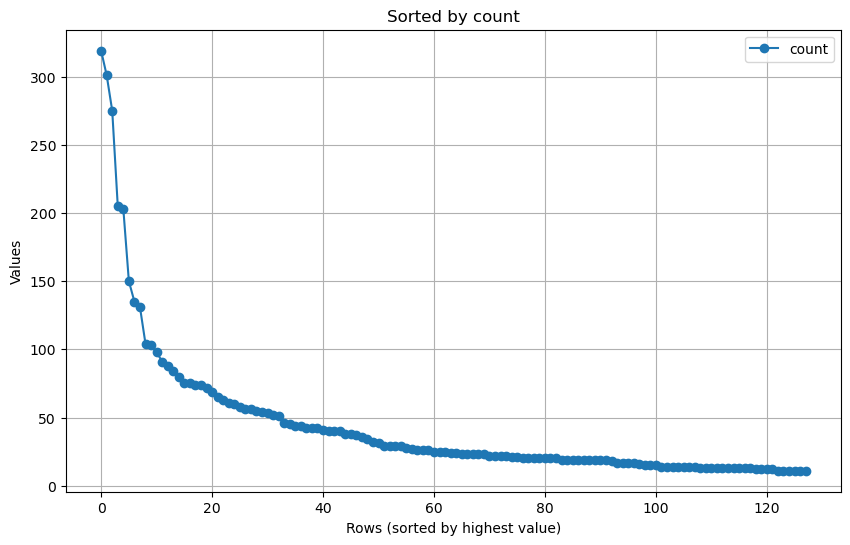

In [16]:
plot(df, 'count')

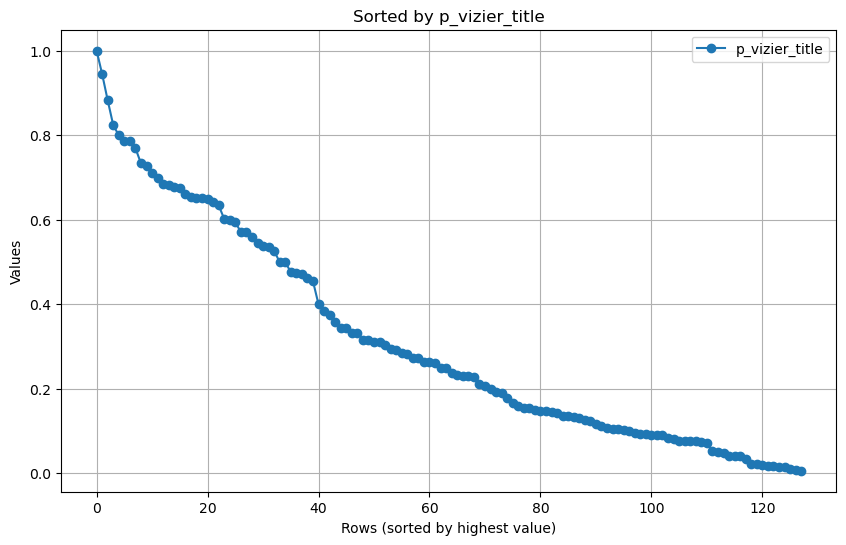

In [17]:
plot(df, 'p_vizier_title')

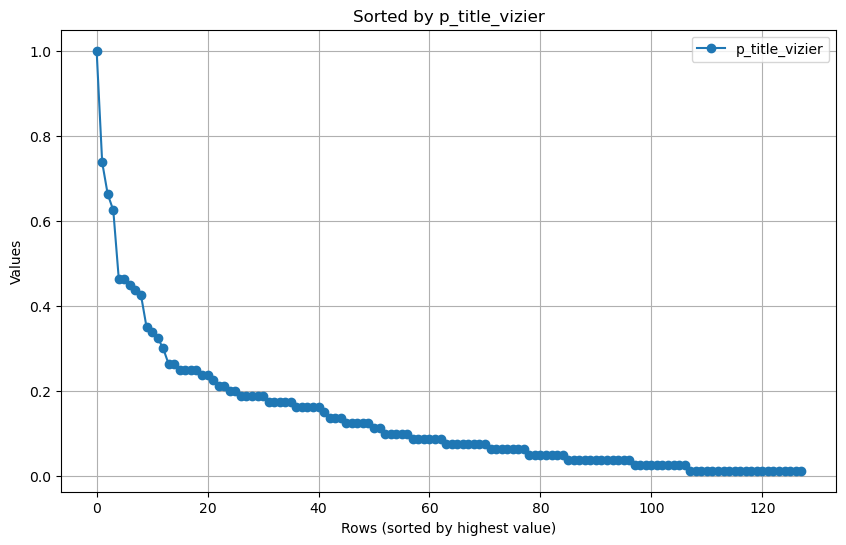

In [18]:
plot(df, 'p_title_vizier')

**Conclusion of ranked plots:**  
- `P(vizier | title)` drops roughly linearly.  
    - I will use a threshold of `P > 0.5000`.  
- `P(title | vizier)` drops significantly within the first 40 titles.  
    - I will use a threshold of `P > 0.1250`.  
    - This threshold is equivalent to the restriction `count(title | vizier) > 10`, which was used to create **feature version 1**.


**NOTE:**  
- The thresholds were made in a way that **feature version 1** is a subset of **feature version 2**.

### restriction by conditional probabilites

In [19]:
# OVERVIEW
# sort by count
df1 = df.sort_values('count', ascending=False)
print(df1.shape)
pd.concat([df1.head(10), df1.tail(10)])

(128, 5)


,title,p_vizier_title,p_title_vizier,count,translation_of_title
1532,iry xt ncwt,0.0063,0.0250,319,property custodian of the king
512,[imAxw xr] nTr aA,0.0930,0.3500,301,revered with the great god
752,cmr waty,0.1927,0.6625,275,sole companion
807,imAxw,0.1024,0.2625,205,"the honoured one, revered, venerated, the one ..."
486,Xry-Hbt,0.1773,0.4500,203,lector priest The many titles that were append...
498,Xry-tp ncwt,0.1600,0.3000,150,royal chamberlain
2072,zS,0.0074,0.0125,135,scribe
2015,zA.f cmcw,0.0153,0.0250,131,his eldest son
335,Hry-cStA,0.1346,0.1750,104,privy to the secret
526,aD-mr (n) zAb,0.1456,0.1875,103,administrator/boundary official of the king ju...


In [20]:
# RESTRICTION
# sort by p_vizier_title
df1 = df[df['p_vizier_title']>.5000].copy()
df1 = df1.sort_values('p_vizier_title', ascending=False)
p_vizier_title_list = df1['title'].to_list()
print(df1.shape)
df1[:50]

(33, 5)


,title,p_vizier_title,p_title_vizier,count,translation_of_title
0,vizier,1.0000,1.0000,80,NaN
1046,imy-rA Hwt-wrt 6,0.9444,0.2125,18,overseer of the six great law-court
1799,wr 5 (m) pr 9Hwty,0.8824,0.1875,17,Greatest of the Five in the temple of Thoth
1887,xrp iAwt nbwt nTrwt,0.8235,0.1750,17,director of every divine office According to S...
524,aA 8wAw,0.8000,0.2000,20,assistant of Duau
952,imy iz Nxn,0.7857,0.1375,14,councillor of Nekhen(?)
445,Htc(?) Inpw,0.7857,0.1375,14,"... of Anubis(?), (precise reading unknown, me..."
1833,wt(y) Inpw,0.7692,0.1250,13,embalmer of Anubis
1996,zA ncwt n Xt.f cmcw,0.7333,0.1375,15,king's eldest son of his body
1322,imy-rA wabty,0.7273,0.2000,22,overseer of two workshops


In [21]:
# RESTRICTION
# sort by p_title_vizier
df1 = df[df['p_title_vizier']>0.1250].copy()
df1 = df1.sort_values('p_title_vizier', ascending=False)
p_title_vizier_list = df1['title'].to_list()
print(df1.shape)
df1[:50]

(45, 5)


,title,p_vizier_title,p_title_vizier,count,translation_of_title
0,vizier,1.0000,1.0000,80,NaN
81,HAty-a,0.6020,0.7375,98,count
752,cmr waty,0.1927,0.6625,275,sole companion
1541,iry-pat,0.6757,0.6250,74,hereditary prince/nobleman
1389,imy-rA zS(w) a(w) (nw) ncwt,0.7115,0.4625,52,overseer of the royal document scribes
1204,imy-rA kAt nbt (nt) ncwt,0.5362,0.4625,69,overseer of all works of the king
486,Xry-Hbt,0.1773,0.4500,203,lector priest The many titles that were append...
487,Xry-Hbt Hry-tp,0.6604,0.4375,53,chief lector priest
1959,xtm(ty)-bity,0.4722,0.4250,72,sealer of the King of Lower Egypt
512,[imAxw xr] nTr aA,0.0930,0.3500,301,revered with the great god


### select final features set

In [22]:
print(f'{len(p_vizier_title_list)}\tlen of p_vizier_title_list')
print(f'{len(p_title_vizier_list)}\tlen of p_title_vizier_list')

33	len of p_vizier_title_list
45	len of p_title_vizier_list


In [23]:
# make final feature list
title_final_list = set(p_title_vizier_list).union(set(p_vizier_title_list))
# remove vizier column
title_final_list = list(title_final_list - {'vizier'})
len(title_final_list)

49

In [24]:
# check sets dimensions
print(f'INTERSECTION CHECK')
set_A = set(p_title_vizier_list) # A... p_title_vizier_list
set_B = set(p_vizier_title_list) # B... p_vizier_title_list
set_union = set_A.union(set_B)
set_intersection = set_A.intersection(set_B)
missing_in_A = set_B - set_A
missing_in_B = set_A - set_B

print(f'{len(set_union)}\tunion len of A and B')
print(f'{len(set_intersection)}\tintersection len of A and B')
print(f'{len(missing_in_A)}\tlen of missing_in_A')
print(f'{len(missing_in_B)}\tlen of missing_in_B')

INTERSECTION CHECK
50	union len of A and B
28	intersection len of A and B
5	len of missing_in_A
17	len of missing_in_B


In [25]:
# make df with final titles
df_final = df.loc[df['title'].isin(title_final_list), :]
print(f'{df_final.shape}\tshape of df_final')

(49, 5)	shape of df_final


#### overviews of p_vizier_title and p_title_vizier

In [26]:
# overview of p_vizier_title
print(f'{df_final.shape}\tshape of df_final')
df_final.sort_values('p_vizier_title', ascending=False)

(49, 5)	shape of df_final


,title,p_vizier_title,p_title_vizier,count,translation_of_title
1046,imy-rA Hwt-wrt 6,0.9444,0.2125,18,overseer of the six great law-court
1799,wr 5 (m) pr 9Hwty,0.8824,0.1875,17,Greatest of the Five in the temple of Thoth
1887,xrp iAwt nbwt nTrwt,0.8235,0.1750,17,director of every divine office According to S...
524,aA 8wAw,0.8000,0.2000,20,assistant of Duau
445,Htc(?) Inpw,0.7857,0.1375,14,"... of Anubis(?), (precise reading unknown, me..."
952,imy iz Nxn,0.7857,0.1375,14,councillor of Nekhen(?)
1833,wt(y) Inpw,0.7692,0.1250,13,embalmer of Anubis
1996,zA ncwt n Xt.f cmcw,0.7333,0.1375,15,king's eldest son of his body
1322,imy-rA wabty,0.7273,0.2000,22,overseer of two workshops
1389,imy-rA zS(w) a(w) (nw) ncwt,0.7115,0.4625,52,overseer of the royal document scribes


In [27]:
# overview of p_title_vizier
print(f'{df_final.shape}\tshape of df_final')
df_final.sort_values('p_title_vizier', ascending=False)

(49, 5)	shape of df_final


,title,p_vizier_title,p_title_vizier,count,translation_of_title
81,HAty-a,0.6020,0.7375,98,count
752,cmr waty,0.1927,0.6625,275,sole companion
1541,iry-pat,0.6757,0.6250,74,hereditary prince/nobleman
1389,imy-rA zS(w) a(w) (nw) ncwt,0.7115,0.4625,52,overseer of the royal document scribes
1204,imy-rA kAt nbt (nt) ncwt,0.5362,0.4625,69,overseer of all works of the king
486,Xry-Hbt,0.1773,0.4500,203,lector priest The many titles that were append...
487,Xry-Hbt Hry-tp,0.6604,0.4375,53,chief lector priest
1959,xtm(ty)-bity,0.4722,0.4250,72,sealer of the King of Lower Egypt
512,[imAxw xr] nTr aA,0.0930,0.3500,301,revered with the great god
1290,imy-rA prwy-HD,0.6429,0.3375,42,overseer of the two treasuries


### Save result df

In [28]:
print(f'{len(title_final_list)}\tlen of title_final_list')

49	len of title_final_list


In [29]:
df_save = df_vizier_title_male.copy()
df_save = df_save.loc[:, ['ID_person', 'vizier'] + title_final_list]

# save df with title info
save_df(df_save, 'df_vizier_titles_v2_only_titles')

# print df
print(df_save.shape)
df_save.head()

Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_titles_v2_only_titles.csv
(3930, 51)


,ID_person,vizier,wr 5 (m) pr 9Hwty,zA ncwt,xrp (i)m(yw) nTrw,Hry-tp Nxb,Xry-Hbt,zA ncwt n Xt.f cmcw,mDH ncwt qd(w) m prwy,imy-rA prwy-HD,...,imy-rA gc-pr,imy-rA kAt nbt (nt) ncwt,mniw Nxn / zAw Nxn,xrp iAwt nbwt nTrwt,imy iz Nxn,imy-rA zS(w) a(w) (nw) ncwt,iry-pat,HAty-a,xrp SnDt nbt,imAxw xr Wcir
0,322,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,323,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,324,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,325,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,326,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
